In [1]:
import sys
import os

In [2]:
import torch
import torch.nn as nn

In [3]:
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

sys.path.append(os.path.abspath(".."))
from utils import read_features, read_targets, print_info_features, print_info_targets, encode_labels, train_val_split, \
    get_dimensions, get_device, metrics_c, plot_history


## Set Working Device

In [4]:
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


## Read Features and Targets

In [5]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/chronology_prediction"))

In [6]:
target = "HistoricalPeriod"

In [7]:
X = read_features(path, f_type="tensors")
y = read_targets(path, [target])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


In [8]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
	},
}


In [9]:
print_info_targets(y)

{
	train: 
		<class 'pandas.core.frame.DataFrame'>
		shape   = (1719, 1)
		columns = ['HistoricalPeriod'],
	test: 
		<class 'pandas.core.frame.DataFrame'>
		shape   = (191, 1)
		columns = ['HistoricalPeriod'],
}


## Encode Target Labels

In [10]:
y, target_enc, le = encode_labels(y, target)

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


In [11]:
y = {
    subset: torch.tensor(_y[target_enc].values, dtype=torch.long, device=device)
    for subset, _y in y.items()
}
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1719])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
}


## Train-Validation Split


In [12]:
X, y = train_val_split(X, y)

In [13]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
		

In [14]:
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1547])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([172])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
}


## Dimensions

In [15]:
X_dim, y_dim = get_dimensions(X, y, le)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 4


## Torch Datasets and Dataloaders

In [16]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Initialize Model

In [17]:
hidden_size = 512

In [18]:
models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="periods")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="periods")
             for ft_txt, ft_img in feature_type_combos
         }

In [19]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 4]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 512]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 512]                  154,112                   154,112
│    │    └─ReLU: 3-2                    [1, 512]                  [1, 512]                  --                        --
│    │    └─Dropout: 3-3                 [1, 512]                  [1, 512]                  --                        --
├─Sequential: 1-2                        [1, 512]                  [1, 4]                    -- 

## Train Model

In [20]:
criterion = nn.CrossEntropyLoss()
metrics = {m: metrics_c[m] for m in metrics_c.keys()}



** FEATURE SET: TFIDF **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 6 **
** Final Model: **
   train_loss: 0.3816
   val_loss: 0.5705
   target0: [accuracy: 0.7733, precision: 0.3820, recall: 0.3913, f1: 0.3866]


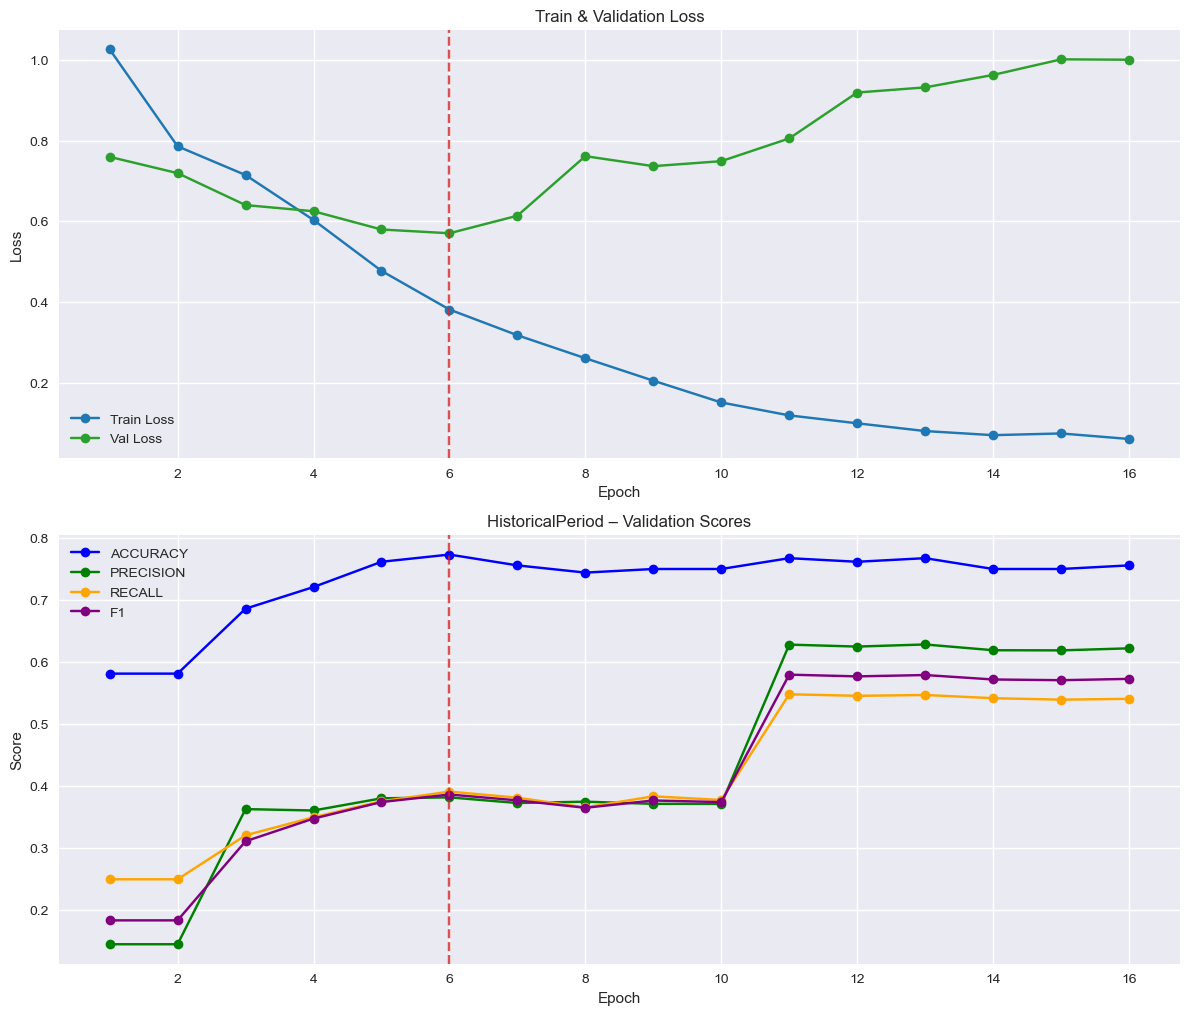



** FEATURE SET: BERT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 22 **
** Final Model: **
   train_loss: 0.5386
   val_loss: 0.6350
   target0: [accuracy: 0.7151, precision: 0.3551, recall: 0.3534, f1: 0.3517]


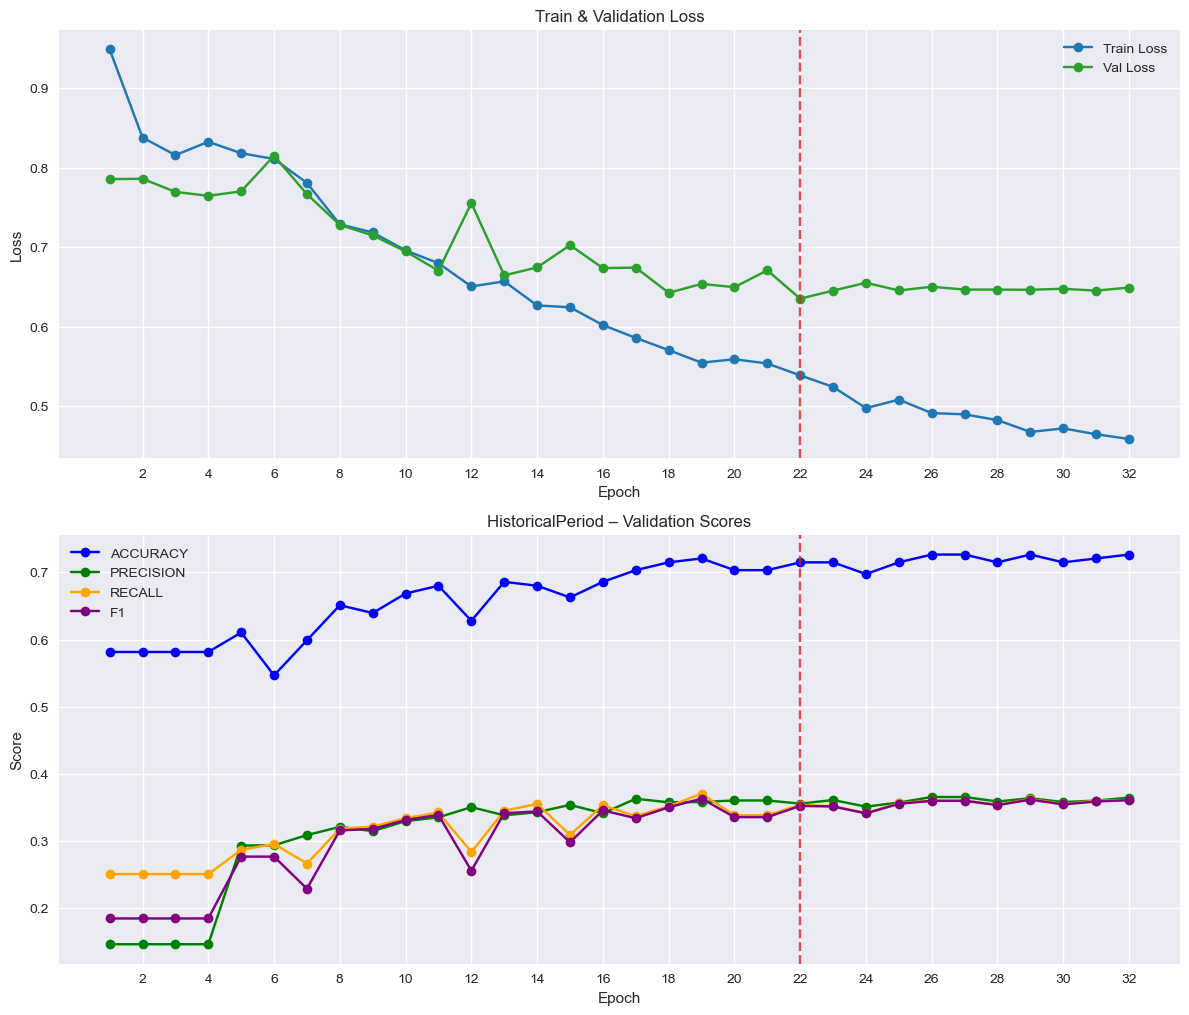



** FEATURE SET: CANNYHOG **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 29 **
** Final Model: **
   train_loss: 0.7983
   val_loss: 0.7699
   target0: [accuracy: 0.5814, precision: 0.1453, recall: 0.2500, f1: 0.1838]


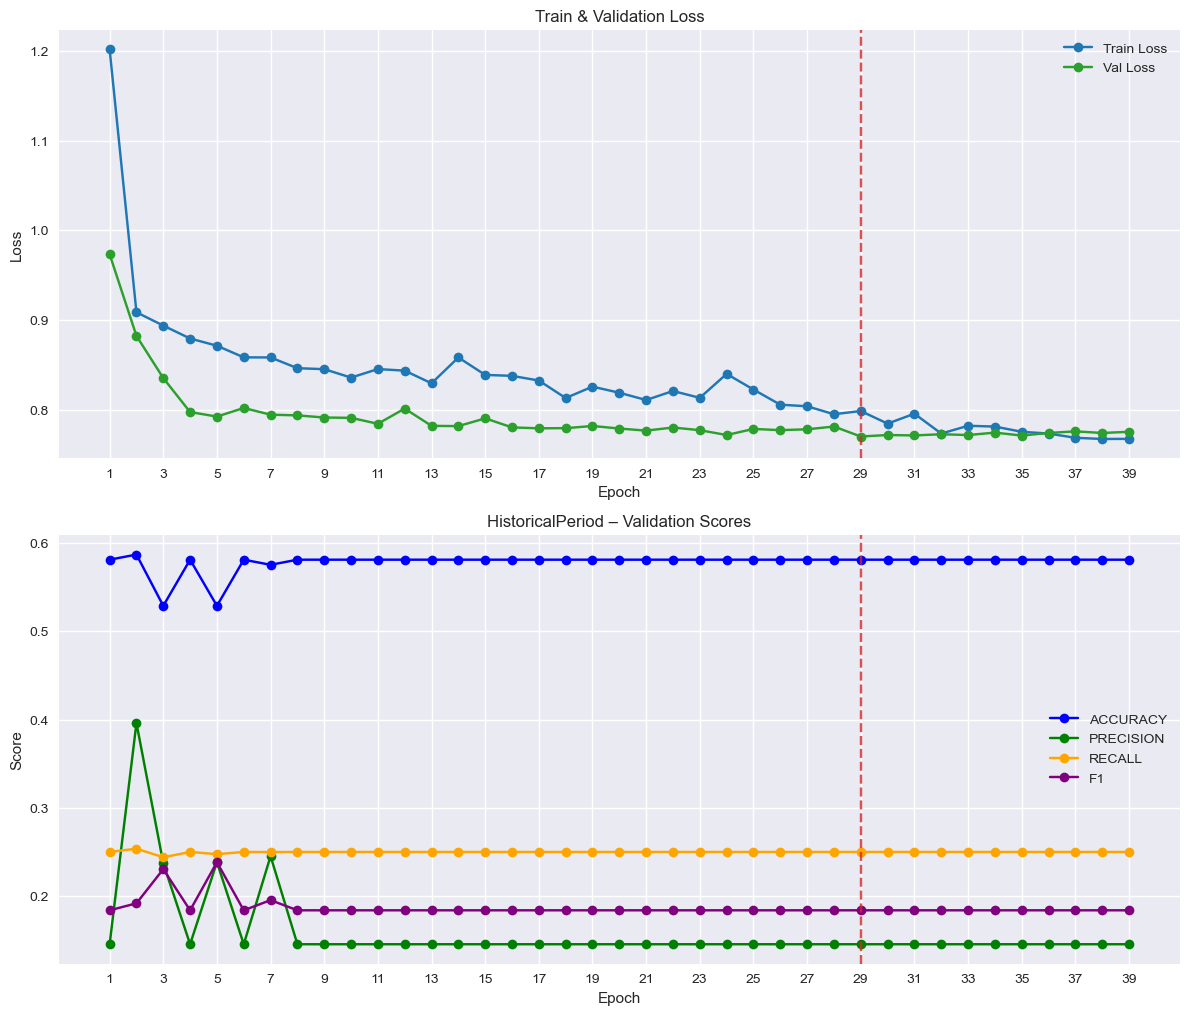



** FEATURE SET: RESNET **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 9 **
** Final Model: **
   train_loss: 0.6038
   val_loss: 0.6705
   target0: [accuracy: 0.6686, precision: 0.3873, recall: 0.4013, f1: 0.3755]


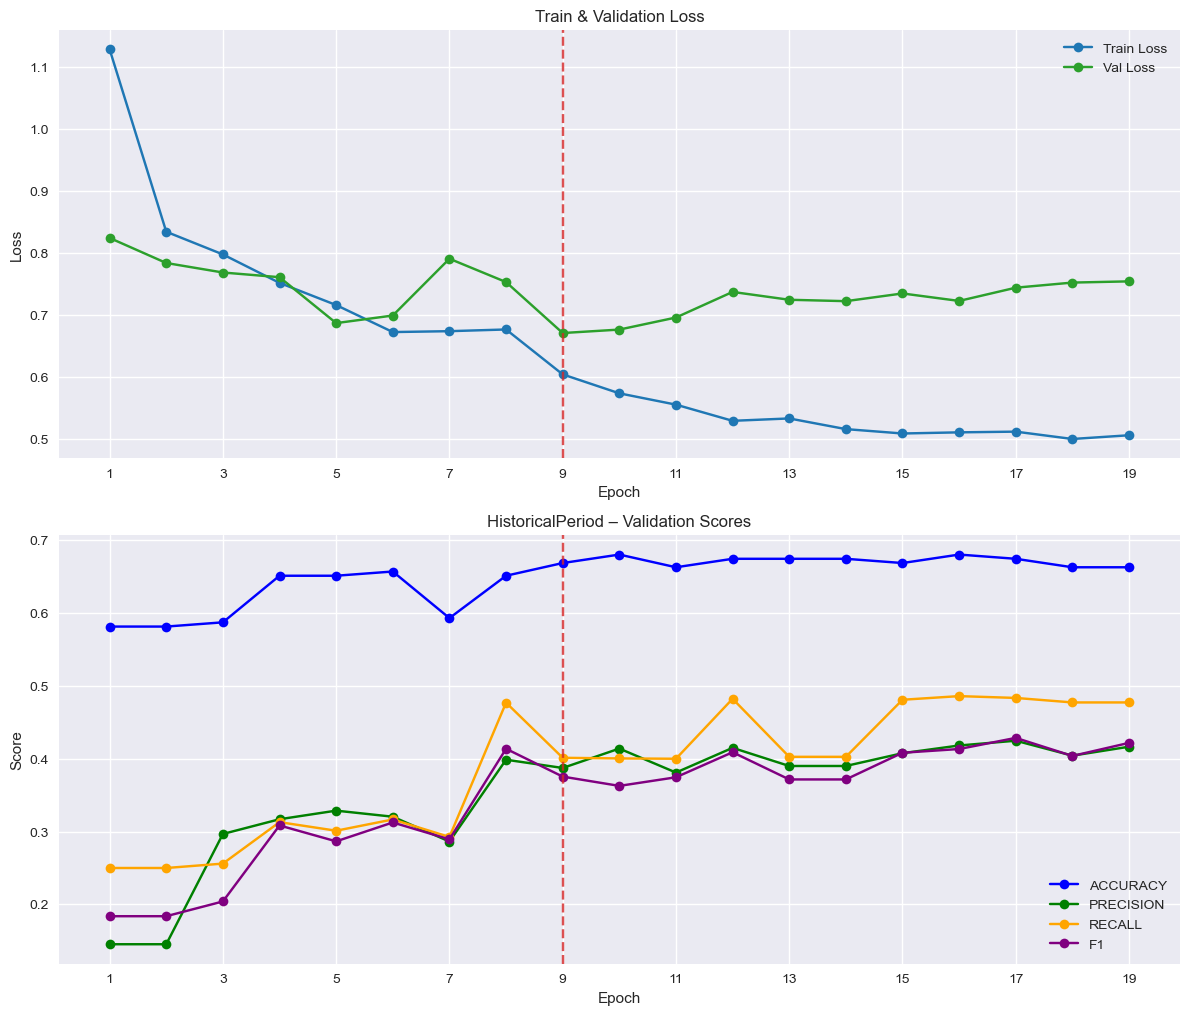



** FEATURE SET: VIT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 5 **
** Final Model: **
   train_loss: 0.7327
   val_loss: 0.7260
   target0: [accuracy: 0.6570, precision: 0.3214, recall: 0.3143, f1: 0.3091]


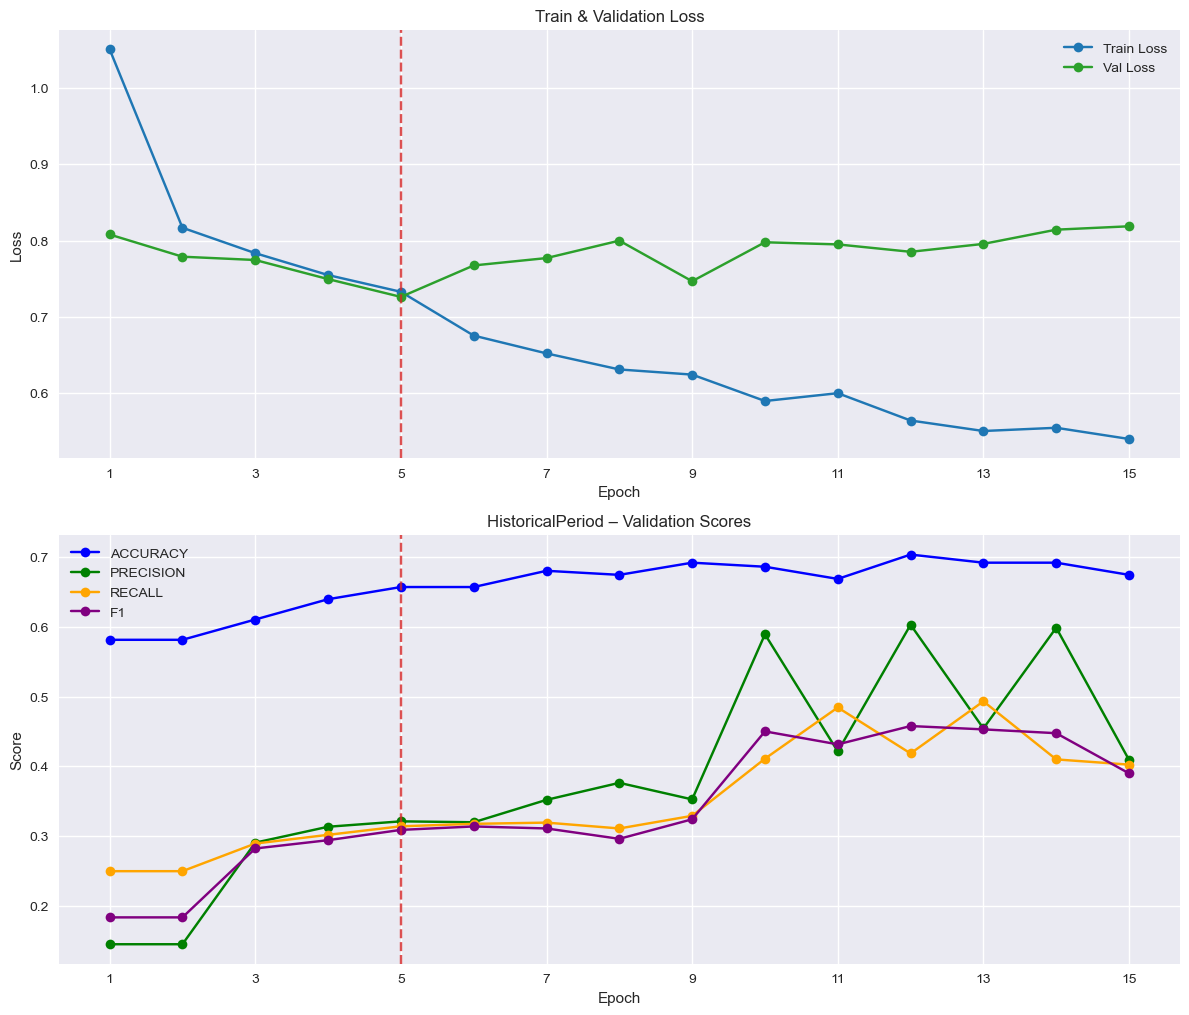



** FEATURE SET: TFIDF + CANNYHOG **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 8 **
** Final Model: **
   train_loss: 0.4273
   val_loss: 0.5713
   target0: [accuracy: 0.7616, precision: 0.3760, recall: 0.3840, f1: 0.3799]


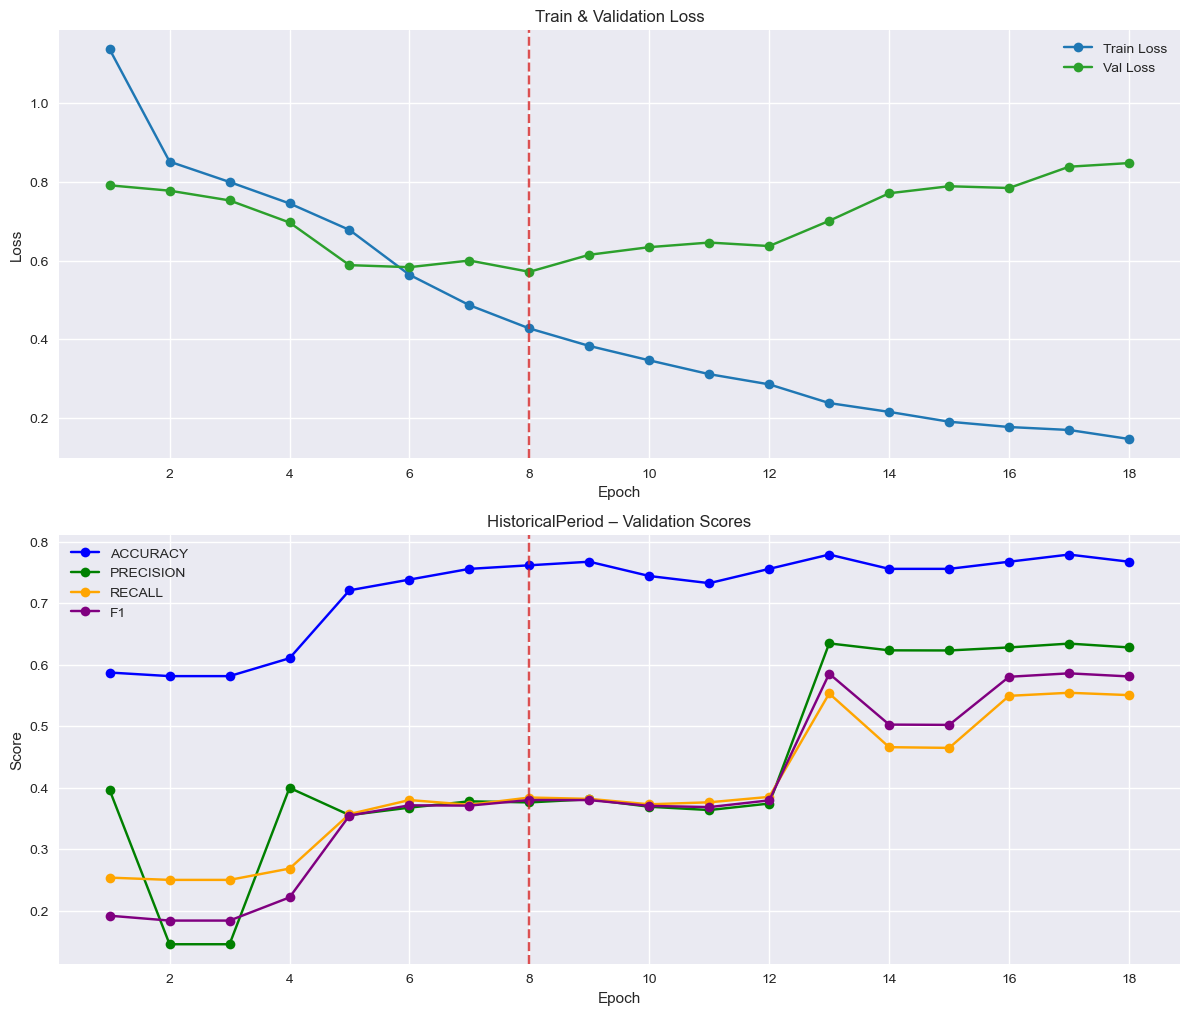



** FEATURE SET: TFIDF + RESNET **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 6 **
** Final Model: **
   train_loss: 0.3534
   val_loss: 0.4915
   target0: [accuracy: 0.7849, precision: 0.6382, recall: 0.4819, f1: 0.5176]


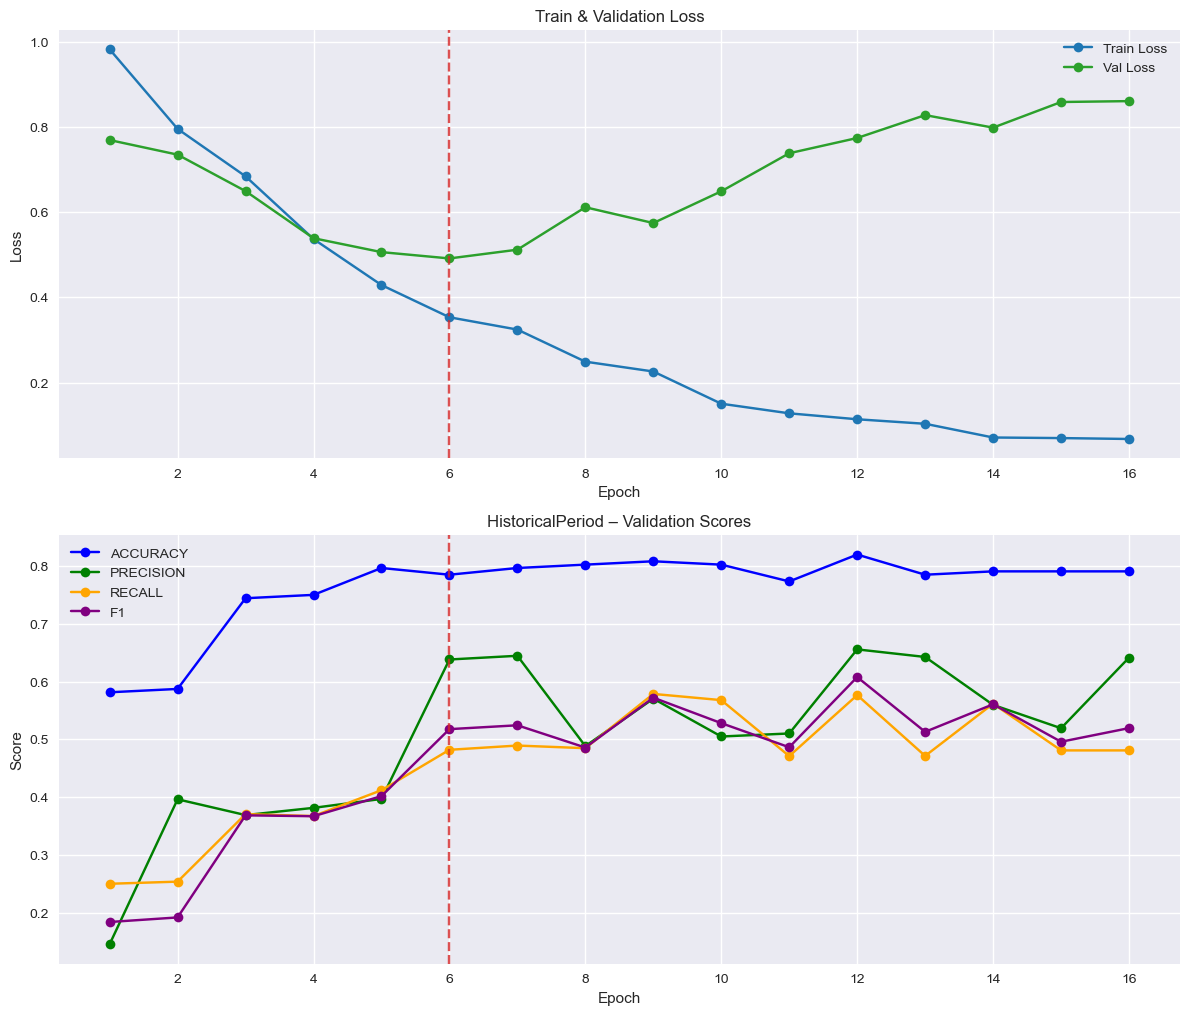



** FEATURE SET: TFIDF + VIT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 5 **
** Final Model: **
   train_loss: 0.4164
   val_loss: 0.4964
   target0: [accuracy: 0.7907, precision: 0.3932, recall: 0.3988, f1: 0.3957]


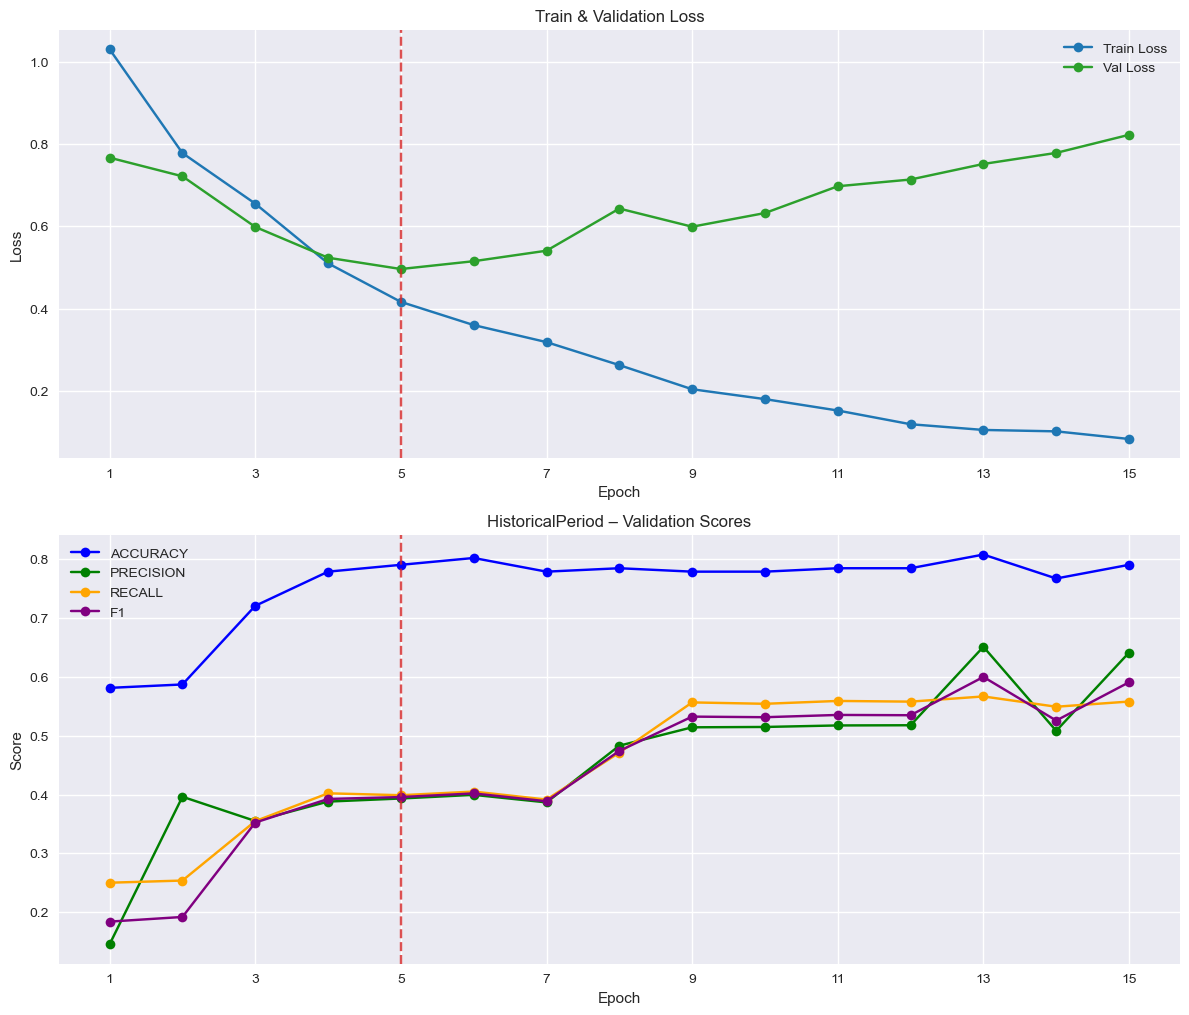



** FEATURE SET: BERT + CANNYHOG **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 27 **
** Final Model: **
   train_loss: 0.4651
   val_loss: 0.6090
   target0: [accuracy: 0.7267, precision: 0.3596, recall: 0.3607, f1: 0.3586]


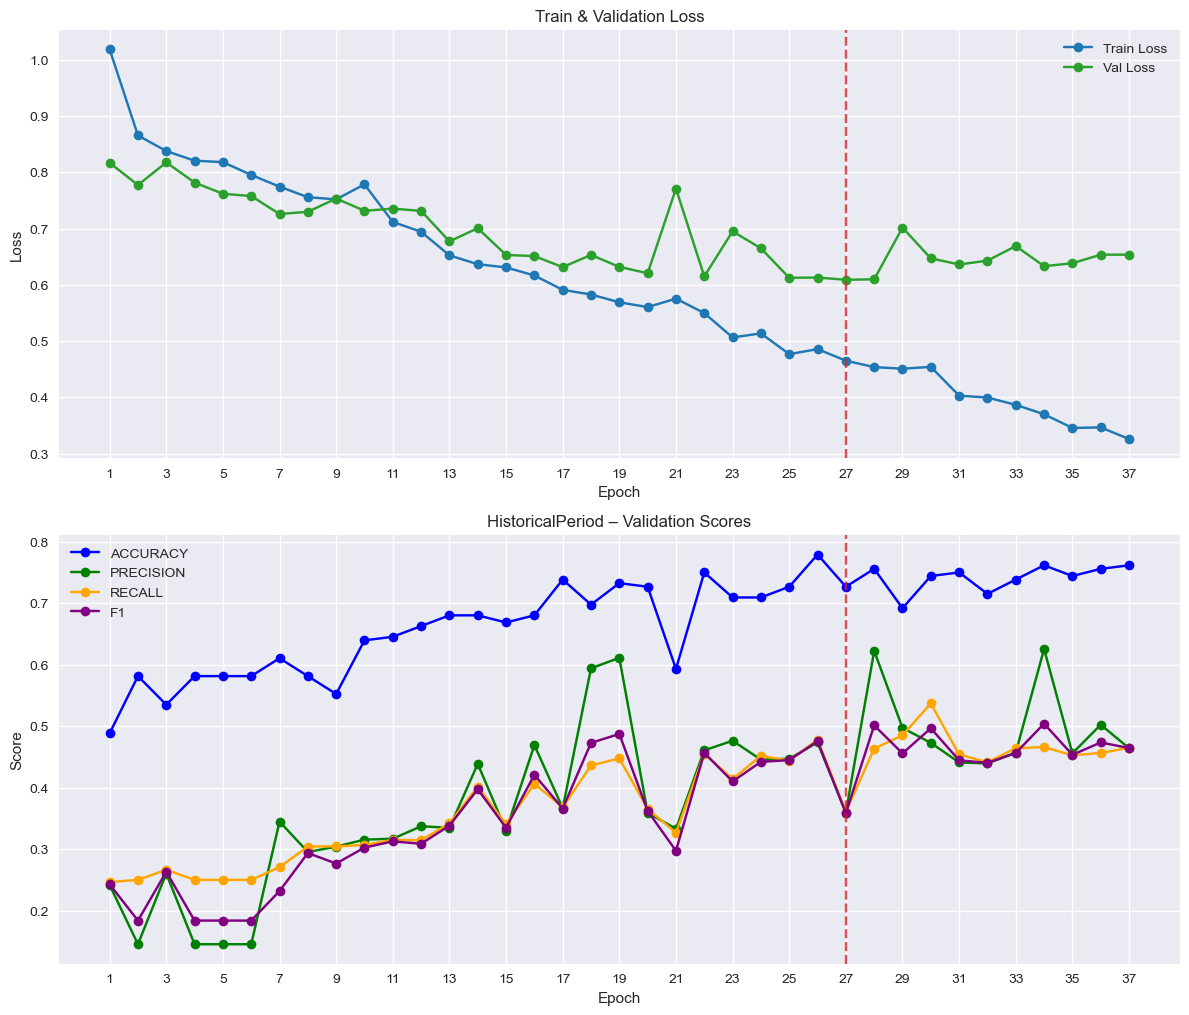



** FEATURE SET: BERT + RESNET **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 7 **
** Final Model: **
   train_loss: 0.5573
   val_loss: 0.6453
   target0: [accuracy: 0.7442, precision: 0.5376, recall: 0.5440, f1: 0.5387]


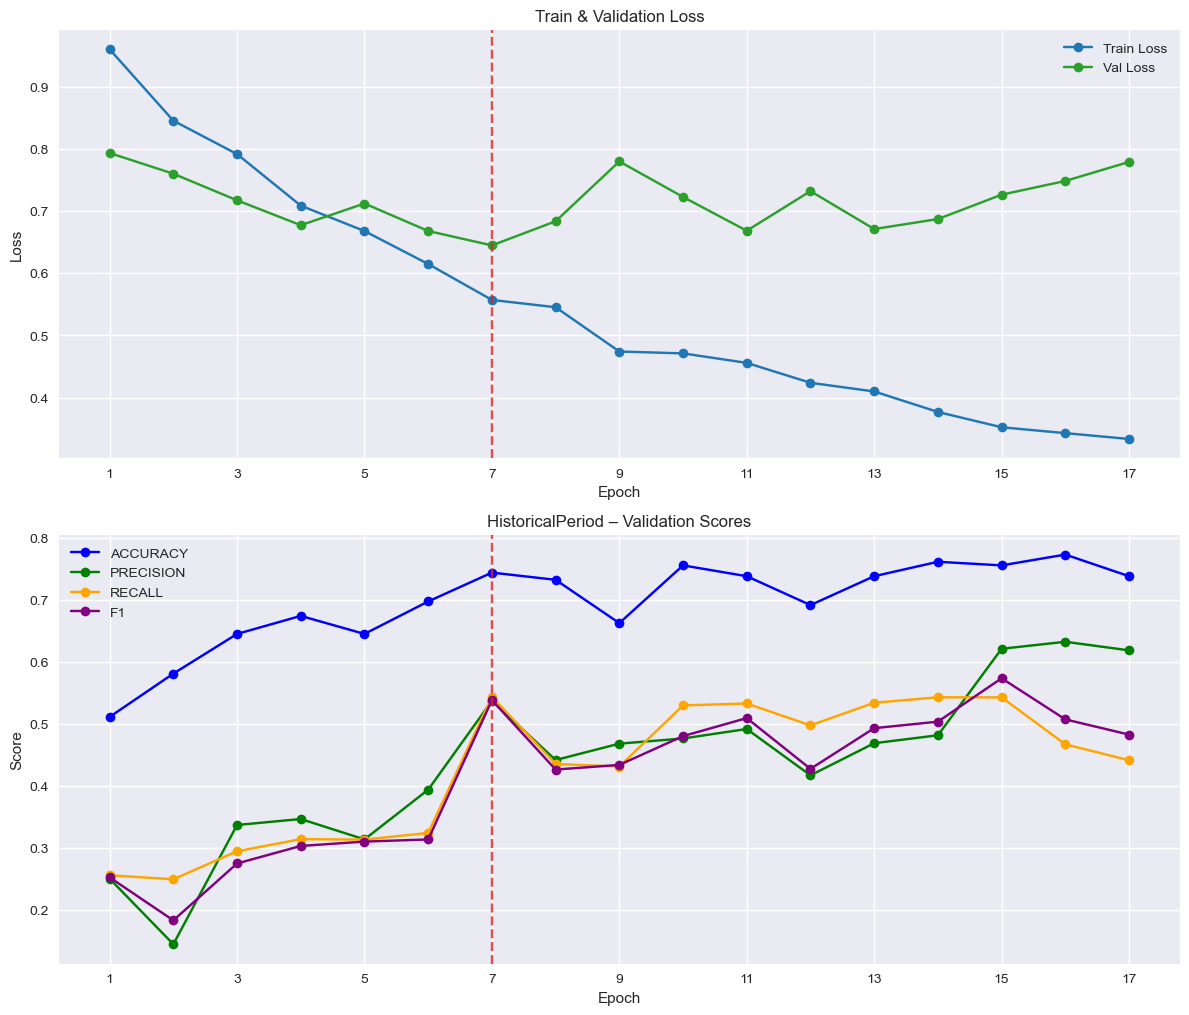



** FEATURE SET: BERT + VIT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 10 **
** Final Model: **
   train_loss: 0.5102
   val_loss: 0.6847
   target0: [accuracy: 0.7558, precision: 0.6228, recall: 0.4647, f1: 0.5018]


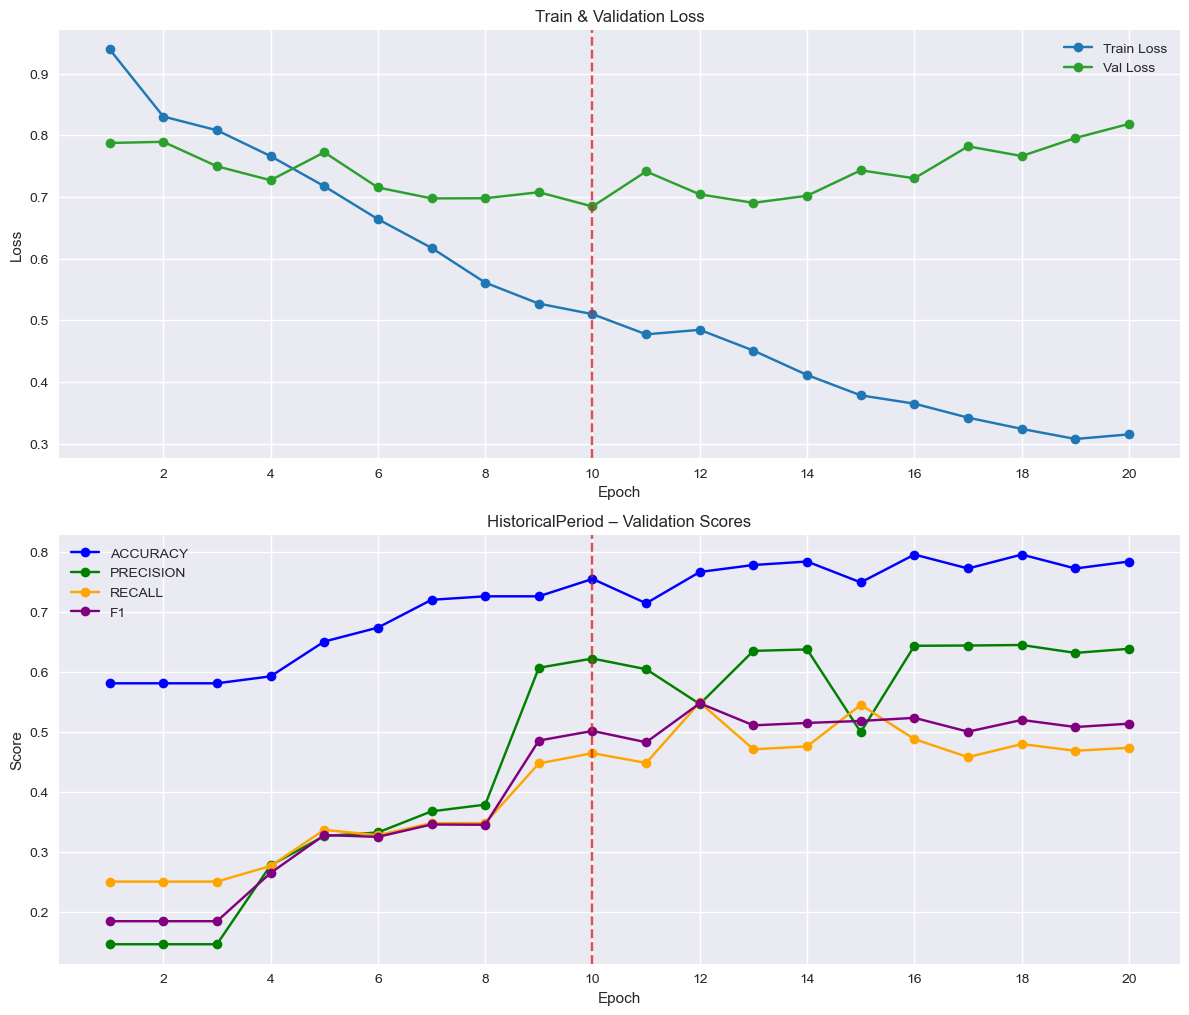

In [21]:
for ft, model in models.items():
    # if ft != "bert": continue
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, patience=10)
    plot_history(history, [target])